## Scenario 1

Non-age structured model with b~=0

* training data: (samples of) WF model with $b\in[-0.001,0.0006]$
* observed data: samples (n=50,100,500,1000,2000) from WF model with specific $b_i$ values 
* outcome: 1-P(neutral)

We plot the $b_i$ values on the x-axis and the 1-P(neutral ) on the y-axis and compare this to the rejection probability obtained from the Ewens-Watterson test.

In [1]:
import os
import matplotlib.pyplot as plt
plt.style.use("seaborn-whitegrid")

In [2]:
%run ../src/dataset.py
%run ../src/augmentation.py
%run ../src/simulation.py
%run ../src/utils.py

In [3]:
def load_data(fp, draws=1):
    data = {}
    for n in (100, 500, 1000, 2000):
        transform = Compose(Sampler(n=n, draws=draws), HillNumbers(q_step=0.25))
        data[n] = PresimulatedDataset.load(fp, transform=transform)
    return data

In [4]:
SCENARIO1_TRAINDATA = load_data("../data/scenario-1-trainset-new.npz")

In [7]:
import json

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.inspection import permutation_importance

Estimator = RandomForestClassifier


with open("clf_params-rf.json") as f:
    PARAMS = json.load(f)

models = {}

for n in (100, 500, 1000, 2000):
    data = SCENARIO1_TRAINDATA[n]
    X, theta = data.dataset, data.theta
    X_train, X_dev, theta_train, theta_dev = train_test_split(
        X, theta, test_size=0.1, shuffle=True)

    y_train = (theta_train[:, 0].numpy() != 0).astype(int)
    y_dev = (theta_dev[:, 0].numpy() != 0).astype(int)
    
    clf = Estimator(n_jobs=10, **PARAMS[f"1-{n}"])
    clf.fit(X_train, y_train)

    probs = clf.predict_proba(X_dev)[:, 1]
    score = roc_auc_score(y_dev, probs)
    
    result = permutation_importance(
        clf, X_dev, y_dev, n_repeats=50, scoring="accuracy", n_jobs=10)
    
    models[n] = {
        "clf": clf,
        "dev score": score,
        "permutation importances": result.importances_mean,
        "impurity importances": clf.feature_importances_
    }

In [8]:
models

{100: {'clf': RandomForestClassifier(criterion='entropy', max_depth=10, max_features='log2',
                         min_samples_leaf=4, min_samples_split=12,
                         n_estimators=1100, n_jobs=10),
  'dev score': 0.8545728816136429,
  'permutation importances': array([-0.0035 , -0.00298, -0.00428, -0.00298, -0.0018 , -0.00242,
         -0.0008 , -0.0053 , -0.00464, -0.0043 ,  0.0197 ,  0.02844,
          0.04368]),
  'impurity importances': array([0.01391932, 0.02968908, 0.03152709, 0.03593856, 0.0404014 ,
         0.05394847, 0.06928749, 0.08710774, 0.07586346, 0.12101638,
         0.13838041, 0.14666237, 0.15625824])},
 500: {'clf': RandomForestClassifier(max_depth=10, max_features='log2', min_samples_leaf=3,
                         min_samples_split=8, n_estimators=1500, n_jobs=10),
  'dev score': 0.9031047943148834,
  'permutation importances': array([ 0.11426,  0.07086,  0.01398, -0.0021 , -0.0034 , -0.00222,
          0.0022 ,  0.00228,  0.00318,  0.00654,  0.0

### Gini Impurity based Feature importance

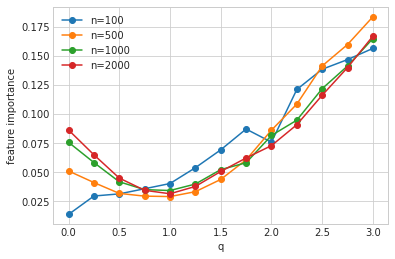

In [9]:
fig, ax = plt.subplots()

q_values = np.arange(0, 3.25, 0.25)

for i, n in enumerate((100, 500, 1000, 2000)):
    ax.plot(q_values, models[n]["impurity importances"], '-o', color=f"C{i}", label=f"n={n}")
ax.set(xlabel="q", ylabel="feature importance")
plt.legend()
plt.savefig(f"../plots/scenario1-feature-importance-gini.png", dpi=300)

### Permutation Based Feature Importance

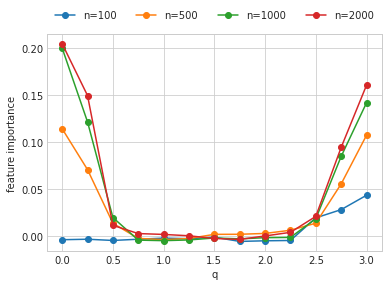

In [10]:
fig, ax = plt.subplots()

q_values = np.arange(0, 3.25, 0.25)

for i, n in enumerate((100, 500, 1000, 2000)):
    ax.plot(q_values, models[n]["permutation importances"], '-o', color=f"C{i}", label=f"n={n}")
ax.set(xlabel="q", ylabel="feature importance")
plt.legend(loc="upper center", ncol=4, bbox_to_anchor=(0.5, 1.15))
plt.savefig(f"../data/scenario1-feature-importance-permutation.png", dpi=300);

In [8]:
SCENARIO1_TESTDATA = load_data("../data/scenario-1-testset-new.npz", draws=10)

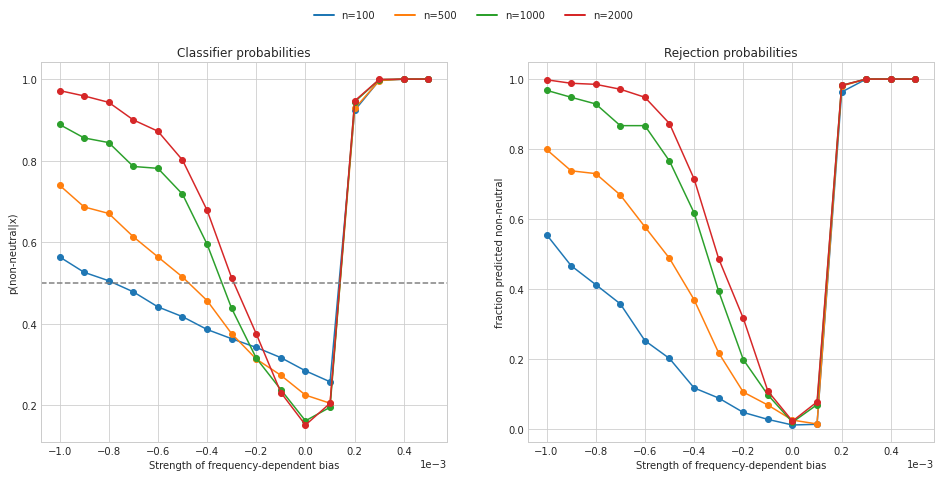

In [9]:
from matplotlib.lines import Line2D
import pandas as pd

fig, axes = plt.subplots(ncols=2, figsize=(16, 7))

for i, n in enumerate((100, 500, 1000, 2000)):
    testdata = SCENARIO1_TESTDATA[n]

    X_test, theta_test = testdata.dataset, testdata.theta
    y_test = (theta_test[:, 0].numpy() != 0).astype(int)
    
    probs = models[n]["clf"].predict_proba(X_test)[:, 1]
    pred = (probs > 0.5).astype(float)
    score = roc_auc_score(y_test, probs)
    
    df = pd.DataFrame(theta_test.numpy(), columns=["b", "p_mut", "p_death", "age_max", "_"])
    df["prob"] = probs
    df["pred"] = pred
    for l, label in enumerate(("prob", "pred")):
        d = df.groupby("b")[label].mean()
        values, labels= d.values, d.index
        axes[l].plot(labels, values, '-o', color=f"C{i}", label=f"n={n}")    
    
axes[0].set(
    ylabel="p(non-neutral|x)", 
    xlabel="Strength of frequency-dependent bias", 
    title="Classifier probabilities",
)

axes[1].set(
    ylabel="fraction predicted non-neutral",
    xlabel="Strength of frequency-dependent bias",
    title="Rejection probabilities",
)

axes[0].ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
axes[1].ticklabel_format(style='sci', axis='x', scilimits=(0, 0))

custom_lines = [Line2D([0], [0], color="C0", lw=2),
                Line2D([0], [0], color="C1", lw=2),
                Line2D([0], [0], color="C2", lw=2),
                Line2D([0], [0], color="C3", lw=2)]
fig.legend(custom_lines, ['n=100', 'n=500', 'n=1000', 'n=2000'], 
          loc="upper center", ncol=4, bbox_to_anchor=(0.5, 1.0), frameon=False)

axes[0].axhline(0.5, ls="--", color="grey")

plt.savefig(f"../plots/scenario1.png", 
            dpi=300, bbox_inches='tight')

## Scenario 2

age-structured model with b=0

* training data: (samples of) age-structured model with copyThresholdHigh $\in [2,\ldots,\text{All}]$ and pDeath $\in [0.02, 0.1]$
* observed data: samples (n=50,100,500,1000,2000) from age-structured model with specific $\text{copyThresholdHigh}_i$ values and $\text{pDeath}_i$ values
*outcome: 1-P(neutral)

As before plot the $\text{copyThresholdHigh}_i$  values on the x-axis and the 1-P(neutral) on the y-axis compare this to the rejection probability obtained from the Ewens-Watterson test (or even 3d plot with copyThresholdHigh_i values and $\text{pDeath}_i$ values on x and y axis)

In [18]:
SCENARIO2_TRAINDATA = load_data("../data/scenario-2-trainset-new.npz")

In [253]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

Estimator = RandomForestClassifier

models_2 = {}

for n in (100, 500, 1000, 2000):
    data = SCENARIO2_TRAINDATA[n]
    X, theta = data.dataset.numpy(), data.theta.numpy()
        
    X_train, X_dev, theta_train, theta_dev = train_test_split(
        X, theta, test_size=0.1, shuffle=True)
    y_train = (theta_train[:, 0] != 0).astype(int)
    y_dev = (theta_dev[:, 0] != 0).astype(int)
        
    clf = Estimator(n_jobs=10, **PARAMS[f"2-{n}"])

    clf.fit(X_train, y_train)

    probs = clf.predict_proba(X_dev)[:, 1]
    score = roc_auc_score(y_dev, probs)
    
    result = permutation_importance(
        clf, X_dev, y_dev, scoring="accuracy", n_repeats=50, n_jobs=10)
    
    models_2[n] = {
        "clf": clf,
        "dev score": score,
        "feature importances": result.importances_mean
    }

In [254]:
models_2

{100: {'clf': RandomForestClassifier(max_depth=10, max_features='sqrt', min_samples_leaf=6,
                         min_samples_split=17, n_estimators=500, n_jobs=10),
  'dev score': 0.7890544994879674,
  'feature importances': array([ 2.230e-02,  3.108e-02,  5.520e-03, -6.000e-05, -2.000e-05,
          2.340e-03,  2.320e-03,  3.820e-03,  5.600e-03,  1.618e-02,
          4.804e-02,  6.138e-02,  6.042e-02])},
 500: {'clf': RandomForestClassifier(criterion='entropy', max_depth=20, min_samples_leaf=9,
                         min_samples_split=6, n_estimators=1300, n_jobs=10),
  'dev score': 0.8511626418551067,
  'feature importances': array([ 0.1158 ,  0.08284,  0.01418, -0.00104, -0.00328, -0.00134,
         -0.00248, -0.0039 ,  0.00322,  0.03332,  0.05664,  0.08744,
          0.10288])},
 1000: {'clf': RandomForestClassifier(max_depth=80, min_samples_leaf=9, min_samples_split=5,
                         n_estimators=500, n_jobs=10),
  'dev score': 0.8679407051282051,
  'feature import

In [94]:
models_2

{100: {'clf': RandomForestClassifier(max_depth=10, max_features='sqrt', min_samples_leaf=6,
                         min_samples_split=17, n_estimators=500, n_jobs=10),
  'dev score': 0.7933303702991864,
  'feature importances': array([ 0.03688,  0.03534,  0.00946, -0.00034, -0.0004 , -0.0051 ,
         -0.00028, -0.0021 ,  0.00126,  0.00664,  0.0386 ,  0.0526 ,
          0.05342])},
 500: {'clf': RandomForestClassifier(criterion='entropy', max_depth=20, min_samples_leaf=9,
                         min_samples_split=6, n_estimators=1300, n_jobs=10),
  'dev score': 0.8585314125650261,
  'feature importances': array([1.2694e-01, 8.0500e-02, 2.0620e-02, 1.2000e-04, 3.2800e-03,
         9.2000e-04, 1.1200e-03, 4.9000e-03, 8.1600e-03, 4.0800e-02,
         8.0660e-02, 1.0952e-01, 1.2480e-01])},
 1000: {'clf': RandomForestClassifier(max_depth=80, min_samples_leaf=9, min_samples_split=5,
                         n_estimators=500, n_jobs=10),
  'dev score': 0.8653508157341608,
  'feature import

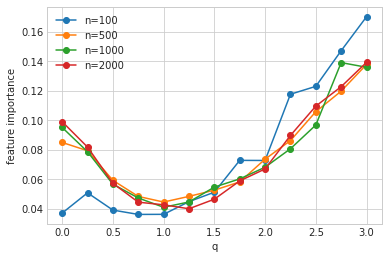

In [251]:
fig, ax = plt.subplots()

q_values = np.arange(0, 3.25, 0.25)

for i, n in enumerate((100, 500, 1000, 2000)):
    ax.plot(q_values, models_2[n]["clf"].feature_importances_, '-o', color=f"C{i}", label=f"n={n}")
ax.set(xlabel="q", ylabel="feature importance")
plt.legend()

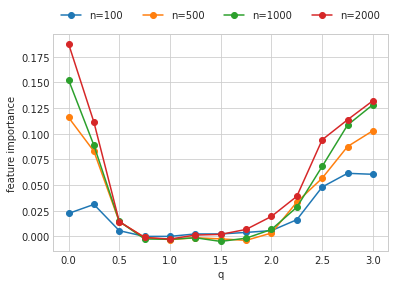

In [255]:
fig, ax = plt.subplots()

q_values = np.arange(0, 3.25, 0.25)

for i, n in enumerate((100, 500, 1000, 2000)):
    ax.plot(q_values, models_2[n]["feature importances"], '-o', color=f"C{i}", label=f"n={n}")
ax.set(xlabel="q", ylabel="feature importance")
plt.legend(loc="upper center", ncol=4, bbox_to_anchor=(0.5, 1.15))
plt.savefig(f"../data/scenario2-feature-importance-permutation.png", dpi=300);

In [45]:
SCENARIO2_TESTDATA = load_data("../data/scenario-2-testset-new.npz", draws=10)

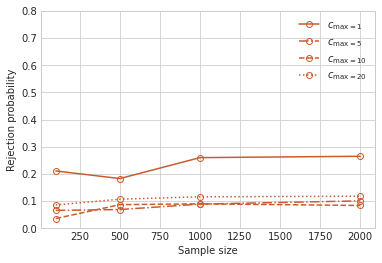

In [97]:
import pandas as pd

fig, ax = plt.subplots()

sample_sizes = np.array([100, 500, 1000, 2000])
cmax = np.array([1, 5, 10, 20])
p_death = 0.02
results = np.zeros((4, 4))
for j, n in enumerate(sample_sizes):
    testdata = SCENARIO2_TESTDATA[n]

    X_test, theta_test = testdata.dataset.numpy(), testdata.theta.numpy()
    y_test = (theta_test[:, 0] != 0).astype(int)

    index = (theta_test[:, 0] == 0.0) & (theta_test[:, 2] == p_death)

    X_test, y_test = X_test[index], y_test[index]

    probs = models_2[n]["clf"].predict_proba(X_test)[:, 1]
    pred = (probs > 0.5).astype(float)

    df = pd.DataFrame(theta_test[index], columns=["b", "p_mut", "p_death", "age_max", "_"])
    df["pred"] = pred
    d = df.groupby("age_max")["pred"].mean()
    results[j] = d.values
    
results = results.T
ls = '-', '-.', '--', 'dotted'
for j, n in enumerate(sample_sizes):
    ax.plot(sample_sizes, results[j], ls=ls[j], marker='o', markerfacecolor='none',
            color="#C95B2E", label=f"$c_{{\\mathrm{{max}} = {cmax[j]}}}$")
ax.legend()
ax.set(xlabel="Sample size", ylabel="Rejection probability", ylim=(0, 0.8))
plt.savefig(f"../data/scenario2-cmax-plot.png", dpi=300);

## Scenario 3

age-structured model with $b \approx 0$

* training data: (samples of) age-structured model with copyThresholdHigh $\in[2,…,All]$ and pDeath $\in [0.02,0.1]$ and $b \in[-0.001,0.0006]$
* observed data: samples (n=50,100,500,1000,2000) from age-structured model with specific copyThresholdHigh_i values and pDeath_i values and $b_i$ values
* outcome: 1-P(neutral)

In [80]:
betas = np.array(
    [-0.001, -0.0008, -0.0006, -0.0004, -0.0002, -0.0001, 
     0, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005])

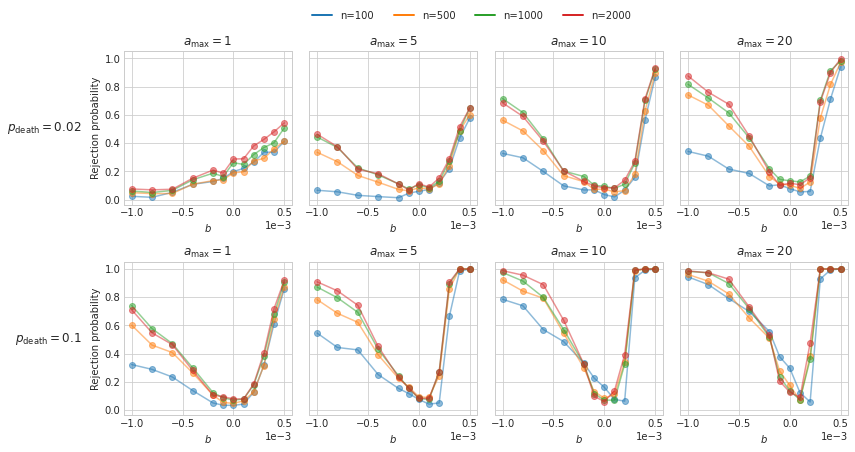

In [258]:
import pandas as pd
import sklearn.metrics as metrics
from matplotlib.lines import Line2D

fig, axes = plt.subplots(ncols=4, nrows=2, sharey=True, figsize=(12, 6))

roc_curves = {}

for j, n in enumerate((100, 500, 1000, 2000)):
    testdata = SCENARIO2_TESTDATA[n]

    for i, p_death in enumerate((0.02, 0.1)):

        X_test, theta_test = testdata.dataset.numpy(), testdata.theta.numpy()
        y_test = (theta_test[:, 0] != 0).astype(int)
        
        index = ((theta_test[:, 2] == p_death) & np.isin(theta_test[:, 0], betas))
        
        X_test, y_test = X_test[index], y_test[index]

        probs = models_2[n]["clf"].predict_proba(X_test)[:, 1]
        pred = (probs >= 0.5).astype(float)

        df = pd.DataFrame(theta_test[index], columns=["b", "p_mut", "p_death", "age_max", "_"])
        df["pred"] = pred
        df["prob"] = probs
        for k, (age, g) in enumerate(df.groupby("age_max")):
            roc_curves[n, p_death, age] = metrics.roc_curve((
                g["b"] != 0).astype(int).values, g["prob"].values)
            g = g.groupby("b")["pred"].mean()
            axes[i, k].plot(g.index, g.values, '-o', color=f"C{j}", alpha=0.5)
            axes[i, k].set(xlabel="$b$", title=f"$a_{{\\mathrm{{max}}}} = {int(age) - 1}$")
            axes[i, k].ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
    
        axes[i, 0].set(ylabel="Rejection probability")

rows = [f'$p_{{\\mathrm{{death}}}} = {v}$' for v in (0.02, 0.1)]
pad = 5
for ax, row in zip(axes[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')
    
custom_lines = [Line2D([0], [0], color="C0", lw=2),
                Line2D([0], [0], color="C1", lw=2),
                Line2D([0], [0], color="C2", lw=2),
                Line2D([0], [0], color="C3", lw=2)]
fig.legend(custom_lines, ['n=100', 'n=500', 'n=1000', 'n=2000'], 
          loc="upper center", ncol=4, bbox_to_anchor=(0.55, 1.05), frameon=False)

plt.tight_layout()
plt.savefig("../data/scenario3-rejection.png", dpi=300, bbox_inches='tight')

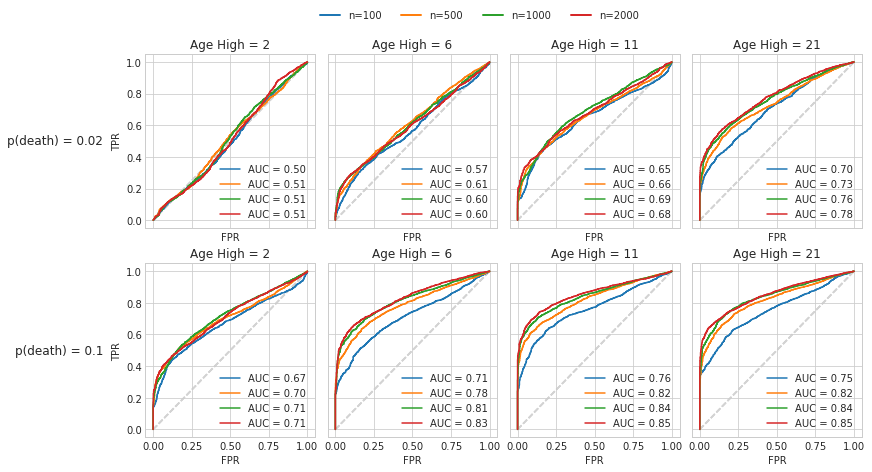

In [18]:
fig, axes = plt.subplots(
    nrows=2, ncols=4, sharey=True, sharex=True, figsize=(12, 6),
    constrained_layout=True
)
for j, n in enumerate((100, 500, 1000, 2000)):
    for i, p_death in enumerate((0.02, 0.1)):
        for k, age in enumerate((2, 6, 11, 21)):
            fpr, tpr, _ = roc_curves[n, p_death, age]
            roc_auc = metrics.auc(fpr, tpr)
            axes[i, k].plot(
                fpr, tpr, '-', color=f"C{j}", label=f"AUC = {roc_auc:.2f}")
            axes[i, k].set(xlabel="FPR", title=f"$a_{{\\mathrm{{max}}}} = {int(age) - 1}$")
            axes[i, k].legend(loc="lower right")
            axes[i, k].plot([0, 1], [0, 1], color="lightgrey", linestyle="--", zorder=-1)
        axes[i, 0].set(ylabel="TPR")
        
rows = [f'p(death) = {v}' for v in (0.02, 0.1)]
pad = 5
for ax, row in zip(axes[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')
    
custom_lines = [Line2D([0], [0], color="C0", lw=2),
                Line2D([0], [0], color="C1", lw=2),
                Line2D([0], [0], color="C2", lw=2),
                Line2D([0], [0], color="C3", lw=2)]
fig.legend(custom_lines, ['n=100', 'n=500', 'n=1000', 'n=2000'], 
          loc="upper center", ncol=4, bbox_to_anchor=(0.55, 1.08), frameon=False)
plt.savefig("roc_curves.png", dpi=300, bbox_inches='tight')

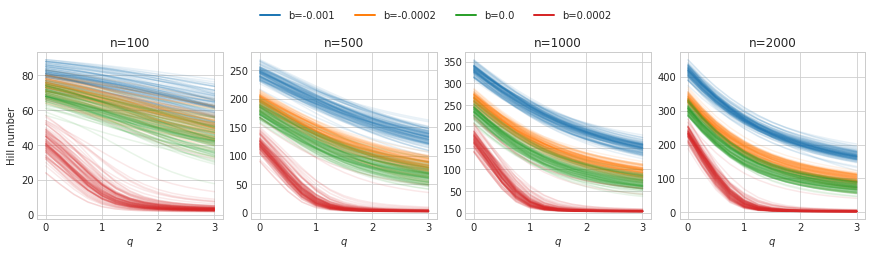

In [19]:
fig, axes = plt.subplots(ncols=4, nrows=1, figsize=(12, 3), constrained_layout=True)
axes = axes.flatten()

betas = np.array([-0.001, -0.0002, 0.0, 0.0002], dtype=np.float32)
q = np.arange(0, 3.25, 0.25)

for j, n in enumerate((100, 500, 1000, 2000)):
    data = SCENARIO1_TESTDATA[n]
    df = pd.DataFrame(
        data.theta.numpy().astype(np.float64), 
        columns=["b", "p_mut", "p_death", "age_max", "timesteps"]
    )
    
    for i, beta in enumerate(betas):
        samples = data.dataset[df["b"] == beta]
        samples = samples[np.random.randint(0, len(samples), 100)]
        for sample in samples:
            axes[j].plot(q, sample, alpha=0.1, color=f"C{i}")
    axes[j].set(xlabel="$q$", title=f"n={n}")

axes[0].set_ylabel("Hill number")

custom_lines = [Line2D([0], [0], color="C0", lw=2),
                Line2D([0], [0], color="C1", lw=2),
                Line2D([0], [0], color="C2", lw=2),
                Line2D([0], [0], color="C3", lw=2)]
fig.legend(custom_lines, ['b=-0.001', 'b=-0.0002', 'b=0.0', 'b=0.0002'], 
          loc="upper center", ncol=4, bbox_to_anchor=(0.5, 1.15), frameon=False)

plt.savefig(f"../plots/hill_numbers_scenario1.png", dpi=300, bbox_inches='tight')

In [182]:
betas = np.unique(SCENARIO2_TESTDATA_FULL[100].theta.numpy()[:, 0])

In [183]:
betas

array([-1.e-03, -9.e-04, -8.e-04, -7.e-04, -6.e-04, -5.e-04, -4.e-04,
       -3.e-04, -2.e-04, -1.e-04,  0.e+00,  1.e-04,  2.e-04,  3.e-04,
        4.e-04,  5.e-04], dtype=float32)

In [176]:
SCENARIO2_TESTDATA_FULL = load_data("../data/scenario-2-testset-full.npz", draws=10)

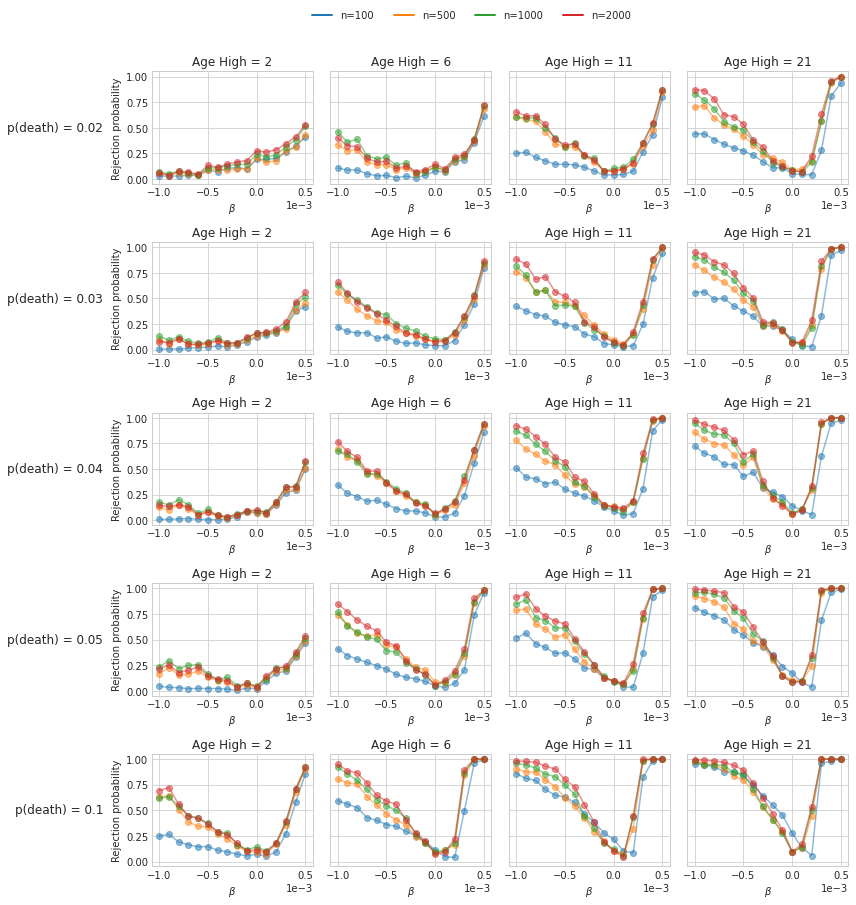

In [184]:
fig, axes = plt.subplots(ncols=4, nrows=5, sharey=True, figsize=(12, 12))

p_death_vals = (0.02, 0.03, 0.04, 0.05, 0.1)
roc_curves = {}

for j, n in enumerate((100, 500, 1000, 2000)):
    testdata = SCENARIO2_TESTDATA_FULL[n]

    for i, p_death in enumerate(p_death_vals):

        X_test, theta_test = testdata.dataset.numpy(), testdata.theta.numpy()
        y_test = (theta_test[:, 0] != 0).astype(int)
        
        index = ((theta_test[:, 2] == p_death) & np.isin(theta_test[:, 0], betas))
        
        X_test, y_test = X_test[index], y_test[index]

        probs = models_2[n]["clf"].predict_proba(X_test)[:, 1]
        pred = (probs > 0.5).astype(float)

        df = pd.DataFrame(theta_test[index], columns=["b", "p_mut", "p_death", "age_max", "_"])
        df["pred"] = pred
        df["prob"] = probs
        for k, (age, g) in enumerate(df.groupby("age_max")):
            roc_curves[n, p_death, age] = metrics.roc_curve((
                g["b"] != 0).astype(int).values, g["prob"].values)
            g = g.groupby("b")["pred"].mean()
            axes[i, k].plot(g.index, g.values, '-o', color=f"C{j}", alpha=0.5)
            axes[i, k].set(xlabel="$\\beta$", title=f"$a_{{\\mathrm{{max}}}} = {int(age) - 1}$")
            axes[i, k].ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
    
        axes[i, 0].set(ylabel="Rejection probability")

rows = [f'p(death) = {v}' for v in p_death_vals]
pad = 5
for ax, row in zip(axes[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')
    
custom_lines = [Line2D([0], [0], color="C0", lw=2),
                Line2D([0], [0], color="C1", lw=2),
                Line2D([0], [0], color="C2", lw=2),
                Line2D([0], [0], color="C3", lw=2)]
fig.legend(custom_lines, ['n=100', 'n=500', 'n=1000', 'n=2000'], 
          loc="upper center", ncol=4, bbox_to_anchor=(0.55, 1.05), frameon=False)

plt.tight_layout()
plt.savefig("../plots/scenario3-rejection-full.png", dpi=300, bbox_inches='tight')

In [185]:
SCENARIO_FIXED_PDEATH_TRAINDATA = load_data("../data/scenario-2-trainset-fixed-pdeath.npz")

In [187]:
with open("clf_params-rf-fixed-pdeath.json") as f:
    FIXED_PDEATH_PARAMS = json.load(f)

Estimator = RandomForestClassifier

models_fixed_pdeath = {}

for n in (100, 500, 1000, 2000):
    data = SCENARIO_FIXED_PDEATH_TRAINDATA[n]
    X, theta = data.dataset.numpy(), data.theta.numpy()
        
    X_train, X_dev, theta_train, theta_dev = train_test_split(
        X, theta, test_size=0.1, shuffle=True)
    y_train = (theta_train[:, 0] != 0).astype(int)
    y_dev = (theta_dev[:, 0] != 0).astype(int)
        
    clf = Estimator(n_jobs=10, **FIXED_PDEATH_PARAMS[f"2-{n}"])

    clf.fit(X_train, y_train)

    probs = clf.predict_proba(X_dev)[:, 1]
    score = roc_auc_score(y_dev, probs)
    
    models_fixed_pdeath[n] = {
        "clf": clf,
        "dev score": score,
    }

In [188]:
models_fixed_pdeath

{100: {'clf': RandomForestClassifier(max_depth=10, min_samples_leaf=9, min_samples_split=18,
                         n_estimators=1200, n_jobs=10),
  'dev score': 0.7446192251684243},
 500: {'clf': RandomForestClassifier(max_depth=20, max_features='log2', min_samples_leaf=9,
                         min_samples_split=7, n_estimators=900, n_jobs=10),
  'dev score': 0.7802684842957487},
 1000: {'clf': RandomForestClassifier(criterion='entropy', max_depth=20, min_samples_leaf=9,
                         min_samples_split=6, n_estimators=1300, n_jobs=10),
  'dev score': 0.8071119999999998},
 2000: {'clf': RandomForestClassifier(criterion='entropy', max_depth=20, max_features='sqrt',
                         min_samples_leaf=9, min_samples_split=11,
                         n_estimators=900, n_jobs=10),
  'dev score': 0.8107091346153845}}

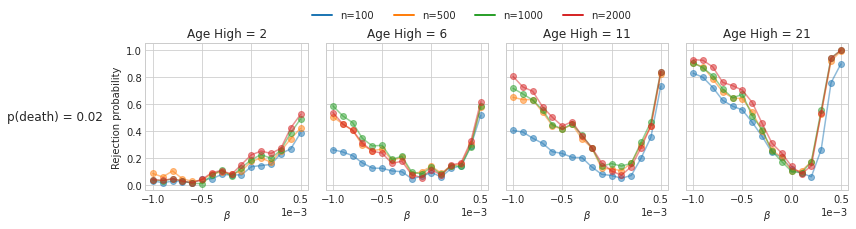

In [194]:
fig, axes = plt.subplots(ncols=4, nrows=1, sharey=True, figsize=(12, 3))

p_death_vals = (0.02,)
roc_curves = {}

for j, n in enumerate((100, 500, 1000, 2000)):
    testdata = SCENARIO2_TESTDATA_FULL[n]

    for i, p_death in enumerate(p_death_vals):

        X_test, theta_test = testdata.dataset.numpy(), testdata.theta.numpy()
        y_test = (theta_test[:, 0] != 0).astype(int)
        
        index = ((theta_test[:, 2] == p_death) & np.isin(theta_test[:, 0], betas))
        
        X_test, y_test = X_test[index], y_test[index]

        probs = models_fixed_pdeath[n]["clf"].predict_proba(X_test)[:, 1]
        pred = (probs > 0.5).astype(float)

        df = pd.DataFrame(theta_test[index], columns=["b", "p_mut", "p_death", "age_max", "_"])
        df["pred"] = pred
        df["prob"] = probs
        for k, (age, g) in enumerate(df.groupby("age_max")):
            roc_curves[n, p_death, age] = metrics.roc_curve((
                g["b"] != 0).astype(int).values, g["prob"].values)
            g = g.groupby("b")["pred"].mean()
            axes[k].plot(g.index, g.values, '-o', color=f"C{j}", alpha=0.5)
            axes[k].set(xlabel="$\\beta$", title=f"$a_{{\\mathrm{{max}}}} = {int(age) - 1}$")
            axes[k].ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
    
        axes[0].set(ylabel="Rejection probability")

rows = [f'p(death) = {v}' for v in p_death_vals]
pad = 5
for ax, row in zip(axes, rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')
    
custom_lines = [Line2D([0], [0], color="C0", lw=2),
                Line2D([0], [0], color="C1", lw=2),
                Line2D([0], [0], color="C2", lw=2),
                Line2D([0], [0], color="C3", lw=2)]
fig.legend(custom_lines, ['n=100', 'n=500', 'n=1000', 'n=2000'], 
          loc="upper center", ncol=4, bbox_to_anchor=(0.55, 1.07), frameon=False)

plt.tight_layout()
plt.savefig("../plots/scenario3-fixed-pdeath-training.png", dpi=300, bbox_inches='tight')

## Learning Curves

### Scenario 1

In [204]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

Estimator = RandomForestClassifier
train_sizes = np.linspace(0.1, 1.0, 10)

train_curve_results_scenario1 = {}

for n in (100, 500, 1000, 2000):
    print(n)
    data = SCENARIO1_TRAINDATA[n]
    X, theta = data.dataset, data.theta
    y = (theta[:, 0].numpy() != 0).astype(int)

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        Estimator(n_jobs=10, **PARAMS[f"1-{n}"]),
        X, y,
        cv=ShuffleSplit(n_splits=10, test_size=0.2, random_state=0),
        n_jobs=10,
        scoring="accuracy",
        train_sizes=train_sizes,
        return_times=True,
    )
    
    train_curve_results_scenario1[n] = {
        "train sizes": train_sizes,
        "train scores": train_scores,
        "test scores": test_scores,
        "fit times": fit_times
    }

100
500
1000
2000


In [202]:
def plot_learning_curve(scores, train_sizes, ax=None, figsize=None, ylim=(0.5, 1.0)):
    if ax is None:
        fig, axes = plt.subplots(ncols=len(scores), sharey=True, sharex=True, figsize=figsize)
    
    for i, n in enumerate(sorted(scores.keys())):
        train_scores_mean = np.mean(scores[n]["train scores"], axis=1)
        train_scores_std = np.std(scores[n]["train scores"], axis=1)
        test_scores_mean = np.mean(scores[n]["test scores"], axis=1)
        test_scores_std = np.std(scores[n]["test scores"], axis=1)
        
        axes[i].fill_between(
            train_sizes,
            train_scores_mean - train_scores_std,
            train_scores_mean + train_scores_std,
            alpha=0.1,
            color=f"C0"
        )
        
        axes[i].fill_between(
            train_sizes,
            test_scores_mean - test_scores_std,
            test_scores_mean + test_scores_std,
            alpha=0.1,
            color="C1"
        )
        
        axes[i].plot(train_sizes, train_scores_mean, 'o-', color="C0")
        axes[i].plot(train_sizes, test_scores_mean, 'o-', color="C1")
        axes[i].set_title(f"$n={n}$", fontsize='medium')
        axes[i].ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
        axes[i].set_ylim(*ylim)
        
    fig.supxlabel('Number of training samples', y=-0.1)        
    axes[0].set(ylabel="Accuracy score")
    plt.figlegend(["Training data", 'Held-out data'], 
                  loc="upper center", ncol=2, bbox_to_anchor=(0.5, 1.1), 
                  frameon=False)
    return fig, axes

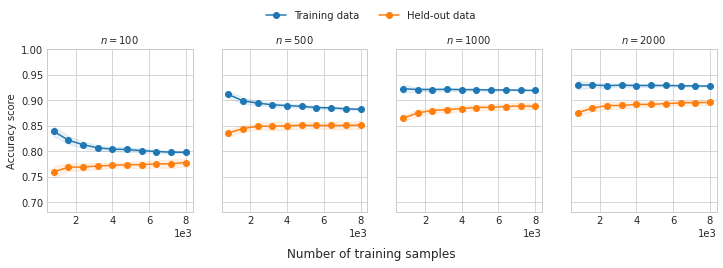

In [224]:
plot_learning_curve(train_curve_results_scenario1, train_sizes, figsize=(12, 3), ylim=(0.68, 1.0))
plt.savefig("learning-curve-scenario1.png", dpi=300, bbox_inches='tight')

### Scenario 2/3

In [207]:
Estimator = RandomForestClassifier
train_sizes = np.linspace(0.1, 1.0, 10)

train_curve_results_scenario2 = {}

for n in (100, 500, 1000, 2000):
    print(n)
    data = SCENARIO2_TRAINDATA[n]
    X, theta = data.dataset, data.theta
    y = (theta[:, 0].numpy() != 0).astype(int)

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        Estimator(n_jobs=10, **PARAMS[f"2-{n}"]),
        X, y,
        cv=ShuffleSplit(n_splits=10, test_size=0.2, random_state=0),
        n_jobs=10,
        scoring="accuracy",
        train_sizes=train_sizes,
        return_times=True,
    )
    
    train_curve_results_scenario2[n] = {
        "train sizes": train_sizes,
        "train scores": train_scores,
        "test scores": test_scores,
        "fit times": fit_times
    }

100
500
1000
2000


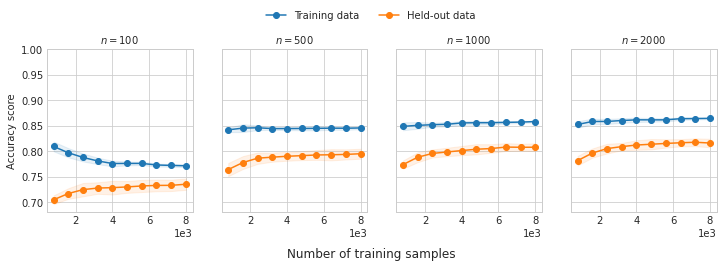

In [225]:
plot_learning_curve(train_curve_results_scenario2, train_sizes, figsize=(12, 3), ylim=(0.68, 1.0))
plt.savefig("learning-curve-scenario2.png", dpi=300, bbox_inches='tight')